In [6]:
import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import requests
from transformers import AutoProcessor, SiglipVisionModel
import torch

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



# Get the image embeddings

In [7]:
def get_clip_embeddings_and_save(images_folder, embeddings_file, model, processor):
    processed_imgs = 0
    
    with h5py.File(embeddings_file, 'w') as h5f:  # Open an HDF5 file
        for idx, filename in enumerate(sorted(os.listdir(images_folder))):
            img_path = os.path.join(images_folder, filename)
            if not filename.endswith(".jpg"):
                    continue  # Skip files that do not end with ".jpg"

            img = Image.open(img_path).convert('RGB')

            inputs = processor(images=img, return_tensors="pt").to(device)
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            pooled_output = outputs.pooler_output  # pooled features
            
            # Save the embedding to the HDF5 file
            h5f.create_dataset(name=f'embedding_{idx}', data=pooled_output.cpu().detach().numpy())
            
            processed_imgs += 1

    print(f"Processed {processed_imgs} images in total")

current_directory = os.getcwd()

scene = "scene0000_00"
object_id = 37

images_folder = os.path.join(current_directory, f"outputs/masked_images/project_without_occlusion/{scene}/{object_id}")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

siglip_vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224").to(device)
siglip_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

embeddings_folder = os.path.join(current_directory, f"outputs/embeddings/SigLip/project_without_occlusion/{scene}")
os.makedirs(embeddings_folder, exist_ok=True)
embeddings_file = os.path.join(embeddings_folder, f"{object_id}.hdf5")

get_clip_embeddings_and_save(images_folder, embeddings_file, siglip_vision_model, siglip_processor)


Using device: mps
Processed 73 images in total


# Single object

## Cosine Similarity

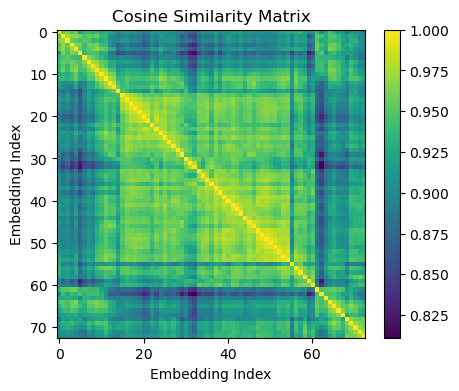

In [8]:
def load_embeddings_from_hdf5(embeddings_file):
    with h5py.File(embeddings_file, 'r') as h5f:
        embeddings = [h5f[f'embedding_{i}'][:] for i in range(len(h5f))]
        embeddings_tensor = torch.tensor(np.stack(embeddings))
    return embeddings_tensor

def calculate_similarity_matrix(embeddings):
    num_embeddings = len(embeddings)
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    
    for i in range(num_embeddings):
        for j in range(num_embeddings):
            if i != j:
                # Flatten the embeddings to 1-D if they are not already
                similarity = 1 - cosine(embeddings[i].flatten(), embeddings[j].flatten())
            else:
                similarity = 1
            similarity_matrix[i, j] = similarity

    return similarity_matrix

def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(5, 4))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

current_directory = os.getcwd()
scene = "scene0000_00"
object_id = 37
embeddings_file = os.path.join(current_directory, f"outputs/embeddings/SigLip/project_without_occlusion/{scene}/{object_id}.hdf5")

embeddings = load_embeddings_from_hdf5(embeddings_file)

similarity_matrix = calculate_similarity_matrix(embeddings.detach().cpu().numpy())
plot_similarity_matrix(similarity_matrix)


### Thresholding Similarity

You might want to set a threshold for similarity values to identify which image pairs are considered similar or dissimilar. For instance, you could define a high similarity threshold (e.g., >0.8) to find very similar pairs or a low similarity threshold (e.g., <0.3) to find very dissimilar pairs.

In [9]:
def find_similar_embeddings(embedding_index, similarity_matrix, threshold):
    similarity_values = similarity_matrix[embedding_index]
    similar_indices = np.where(similarity_values > threshold)[0]
    return similar_indices

embedding_index = 50
threshold = 0.9
similar_indices = find_similar_embeddings(embedding_index, similarity_matrix, threshold)

print(f"Embeddings similar to {embedding_index}: {similar_indices}")

Embeddings similar to 50: [ 0  2  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 56 57 58 59 60 64 65 66 67 68 69 70 71 72]


## Cluster Analysis (K-means)

Use K-Means to group the embeddings into clusters based on their similarity.

Compute Sum of Squared Distances to find optimal K

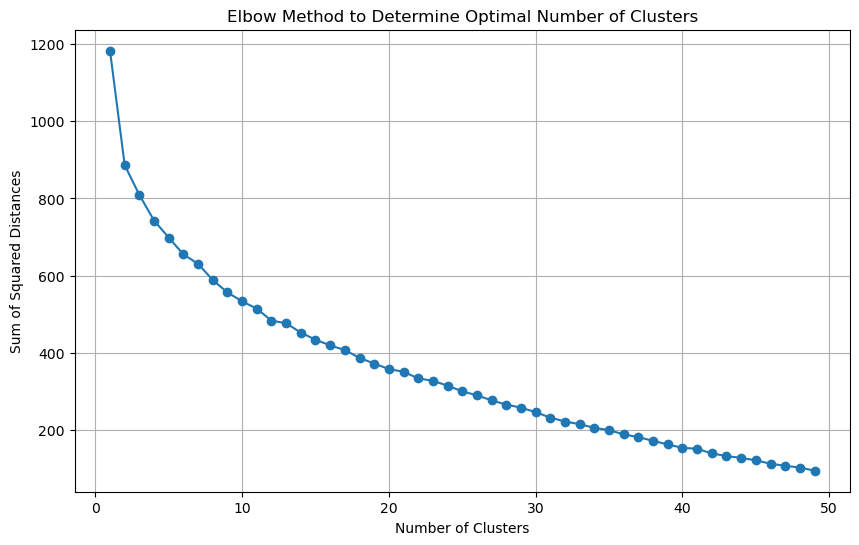

In [10]:
def calculate_sse(embeddings, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
        # Ensure embeddings are 2-dimensional: (n_samples, n_features)
        embeddings_2d = embeddings.reshape(len(embeddings), -1)
        kmeans.fit(embeddings_2d)
        sse.append(kmeans.inertia_)
    return sse

def plot_elbow_curve(k_range, sse):
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.grid(True)
    plt.show()

if isinstance(embeddings, torch.Tensor):
    embeddings_np = embeddings.cpu().detach().numpy()
else:
    embeddings_np = embeddings

k_range = range(1, 50)
sse = calculate_sse(embeddings_np, k_range)
plot_elbow_curve(k_range, sse)


Run K-Means

In [11]:
k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
embeddings_2d = embeddings_np.reshape(embeddings_np.shape[0], -1)
kmeans.fit(embeddings_2d)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

Embedding 50 belongs to cluster 1
Embedding 2 belongs to cluster 6


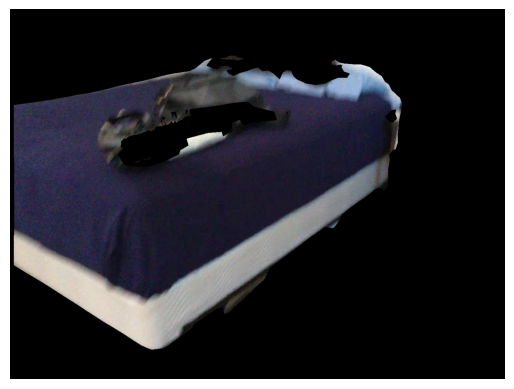

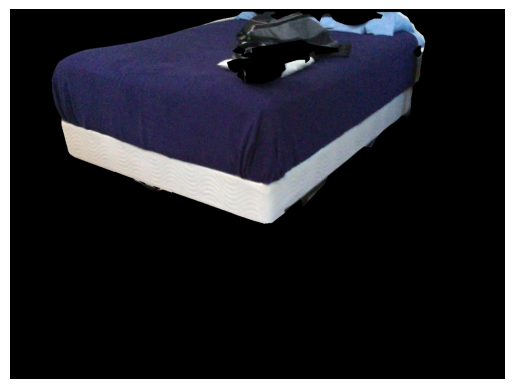

In [13]:
def print_frames_pair(embedding_index_1, embedding_index_2, images_folder):
    for idx, filename in enumerate(sorted(os.listdir(images_folder))):
        if idx == embedding_index_1 or idx == embedding_index_2:
            img_path = os.path.join(images_folder, filename)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

emb_idx_1 = 50
emb_idx_2 = 2

print(f"Embedding {emb_idx_1} belongs to cluster {kmeans.labels_[emb_idx_1]}")
print(f"Embedding {emb_idx_2} belongs to cluster {kmeans.labels_[emb_idx_2]}")
print_frames_pair(emb_idx_1, emb_idx_2, images_folder)

Show labels of each frame

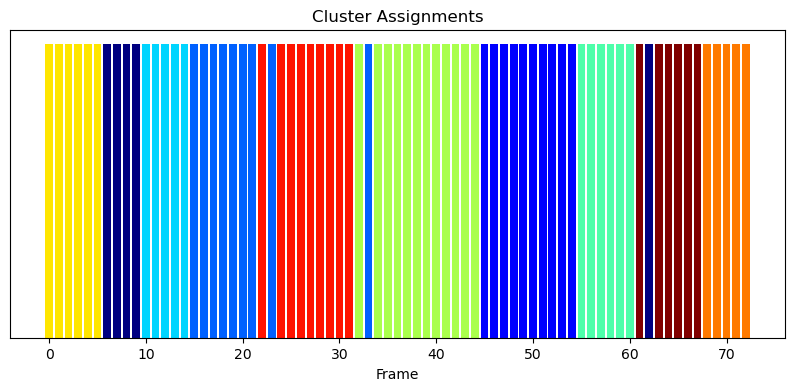

In [14]:
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))
bar_colors = [label_to_color[label] for label in labels]

plt.figure(figsize=(10, 4))
bar_positions = np.arange(len(labels))
plt.bar(bar_positions, np.ones_like(labels), color=bar_colors)

plt.xlabel('Frame')
plt.yticks([])
plt.title('Cluster Assignments')
plt.show()

Show Cosine Similarity Matrix of cluster centers

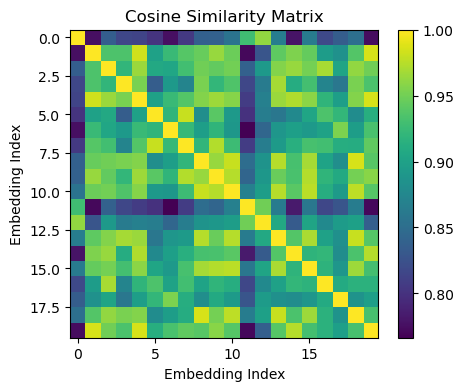

In [18]:
similarity_matrix_center_clusters = cosine_similarity(cluster_centers)
plot_similarity_matrix(similarity_matrix_center_clusters)

Show Cosine Similarity Matrix among one random frame per cluster

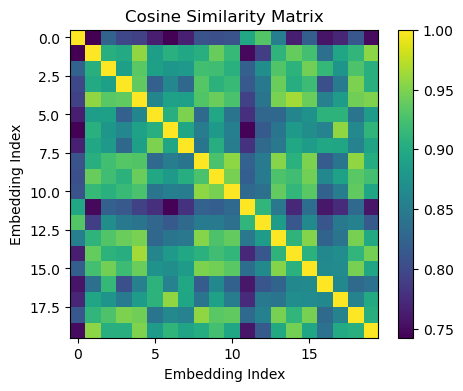

In [19]:
def select_random_frame_per_cluster(embeddings_np, labels, k):
    unique_labels = np.unique(labels)
    selected_frames = []
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_index = np.random.choice(indices)
        selected_frames.append(embeddings_np[selected_index])
    return np.array(selected_frames)


selected_frames = select_random_frame_per_cluster(embeddings_np, labels, k)
similarity_matrix_random_clusters = calculate_similarity_matrix(selected_frames)
plot_similarity_matrix(similarity_matrix_random_clusters)

## Cluster analysis (DBSCAN)

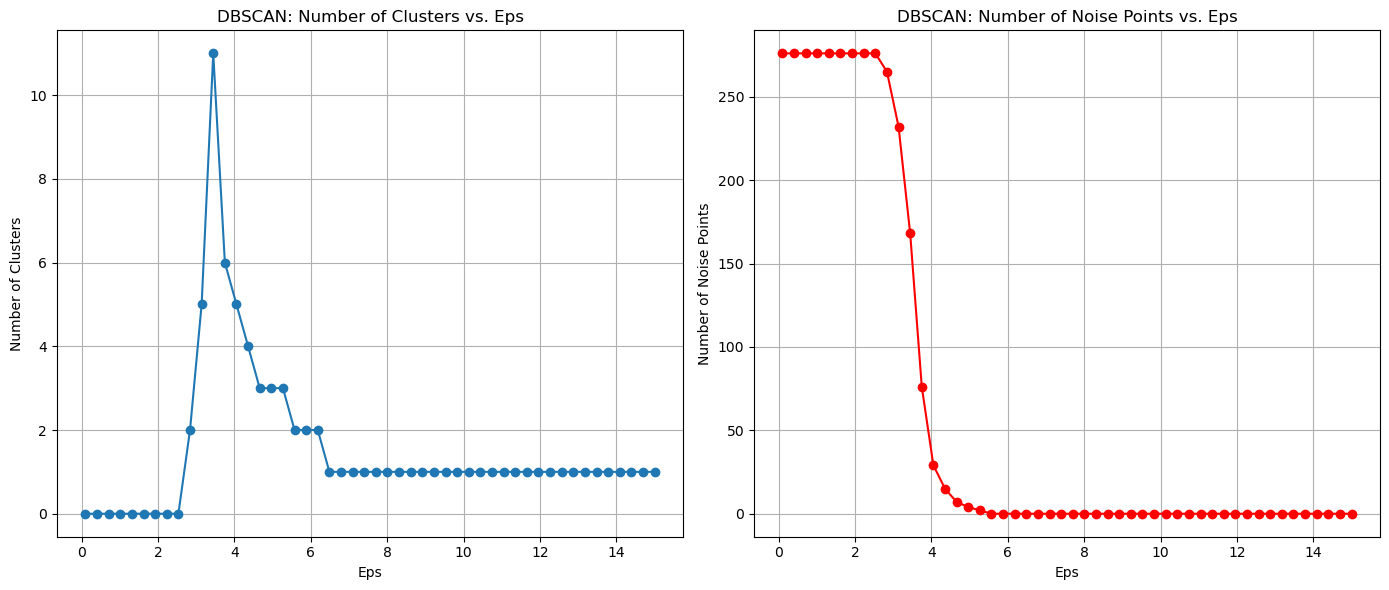

In [32]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import torch

def calculate_dbscan_clusters(embeddings, eps_range, min_samples):
    n_clusters = []
    n_noise = []
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        # Ensure embeddings are 2-dimensional: (n_samples, n_features)
        embeddings_2d = embeddings.reshape(len(embeddings), -1)
        dbscan.fit(embeddings_2d)
        labels = dbscan.labels_
        n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
        n_noise.append(list(labels).count(-1))
    return n_clusters, n_noise

def plot_dbscan_analysis(eps_range, n_clusters, n_noise):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(eps_range, n_clusters, marker='o')
    plt.title('DBSCAN: Number of Clusters vs. Eps')
    plt.xlabel('Eps')
    plt.ylabel('Number of Clusters')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eps_range, n_noise, marker='o', color='red')
    plt.title('DBSCAN: Number of Noise Points vs. Eps')
    plt.xlabel('Eps')
    plt.ylabel('Number of Noise Points')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if isinstance(embeddings, torch.Tensor):
    embeddings_np = embeddings.cpu().detach().numpy()
else:
    embeddings_np = embeddings

eps_range = np.linspace(0.1, 15.0, 50)
min_samples = 5
n_clusters, n_noise = calculate_dbscan_clusters(embeddings_np, eps_range, min_samples)
plot_dbscan_analysis(eps_range, n_clusters, n_noise)


## Pearson correlation

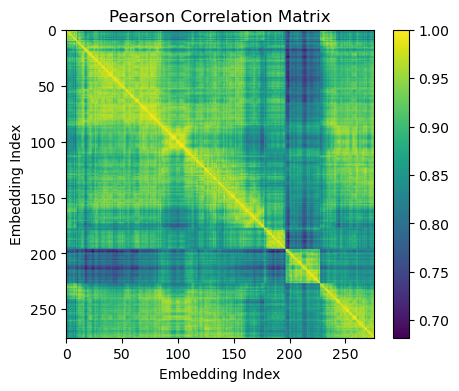

In [22]:
def calculate_pearson_matrix(embeddings):
    num_embeddings = len(embeddings)
    pearson_matrix = np.zeros((num_embeddings, num_embeddings))
    
    for i in range(num_embeddings):
        for j in range(num_embeddings):
            if i != j:
                pearson_matrix[i, j] = np.corrcoef(embeddings[i].flatten(), embeddings[j].flatten())[0, 1]
            else:
                pearson_matrix[i, j] = 1

    return pearson_matrix

def plot_pearson_matrix(pearson_matrix):
    plt.figure(figsize=(5, 4))
    plt.imshow(pearson_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Pearson Correlation Matrix')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

current_directory = os.getcwd()
scene = "scene0000_00"
object_id = 37
embeddings_file = os.path.join(current_directory, f"outputs/embeddings/SigLip/project_with_occlusion/{scene}/{object_id}.hdf5")

embeddings = load_embeddings_from_hdf5(embeddings_file)

pearson_matrix = calculate_pearson_matrix(embeddings.detach().cpu().numpy())
plot_pearson_matrix(pearson_matrix)

is_equal = pearson_matrix == similarity_matrix


## Visualize through PCA

In [33]:
embeddings_np = embeddings.numpy()
# Assuming embeddings_np is originally shaped [n_samples, channels, features]
# Reshape it to [n_samples, channels * features]
embeddings_flat = embeddings_np.reshape(embeddings_np.shape[0], -1)

### 2D visualization

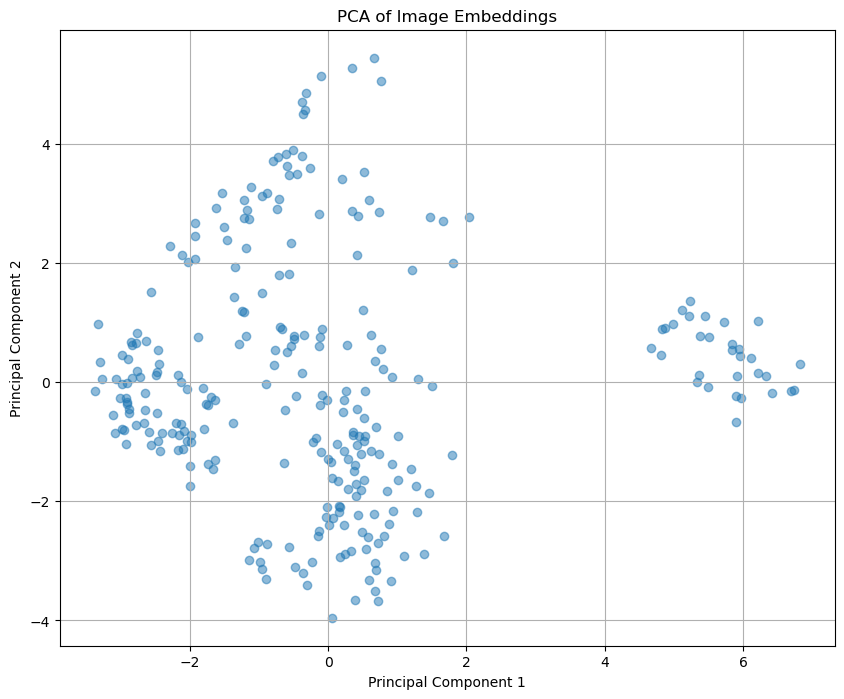

In [34]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_flat[:, :])

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Embeddings')
plt.grid(True)
plt.show()


### 3D visualization

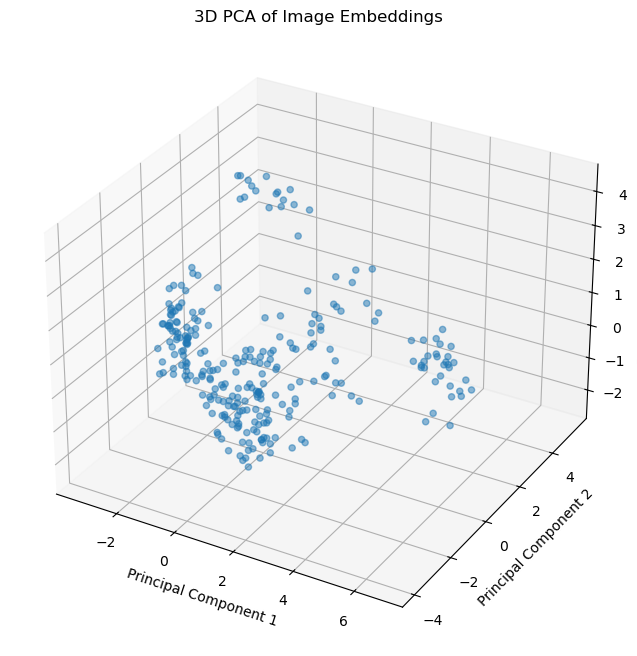

In [35]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
#embeddings_flat = embeddings_flat[:,:]
reduced_embeddings = pca.fit_transform(embeddings_flat[:,:])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of Image Embeddings')
plt.show()

# Multiple objects

## Cosine similarity

Num embeddings 1:  124 Num embeddings 2:  276


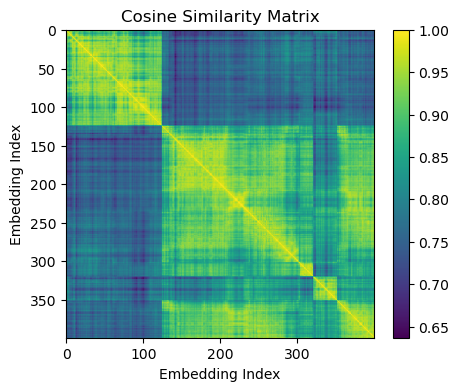

In [37]:
def load_embeddings_from_hdf5(embeddings_file_1, embeddings_file_2):
    with h5py.File(embeddings_file_1, 'r') as h5f:
        embeddings_1 = [h5f[f'embedding_{i}'][:] for i in range(len(h5f))]
        embeddings_tensor_1 = torch.tensor(np.stack(embeddings_1))
    with h5py.File(embeddings_file_2, 'r') as h5f:
        embeddings_2 = [h5f[f'embedding_{i}'][:] for i in range(len(h5f))]
        embeddings_tensor_2 = torch.tensor(np.stack(embeddings_2))
    return embeddings_tensor_1, embeddings_tensor_2

def calculate_similarity_matrix(embeddings):
    num_embeddings = len(embeddings)
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    
    for i in range(num_embeddings):
        for j in range(num_embeddings):
            if i != j:
                # Flatten the embeddings to 1-D if they are not already
                similarity = 1 - cosine(embeddings[i].flatten(), embeddings[j].flatten())
            else:
                similarity = 1
            similarity_matrix[i, j] = similarity

    return similarity_matrix

def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(5, 4))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

current_directory = os.getcwd()
scene_1 = "scene0001_00"
object_id_1 = 1
scene_2 = "scene0000_00"
object_id_2 = 37

embeddings_file_1 = os.path.join(current_directory, f"outputs/embeddings/SigLip/project_with_occlusion/{scene_1}/{object_id_1}.hdf5")
embeddings_file_2 = os.path.join(current_directory, f"outputs/embeddings/SigLip/project_with_occlusion/{scene_2}/{object_id_2}.hdf5")
embeddings_1, embeddings_2 = load_embeddings_from_hdf5(embeddings_file_1, embeddings_file_2)
embeddings = torch.cat([embeddings_1, embeddings_2], dim=0)

num_embeddings_1 = embeddings_1.shape[0]
num_embeddings_2 = embeddings_2.shape[0]
print("Num embeddings 1: ", num_embeddings_1, "Num embeddings 2: ", num_embeddings_2)

similarity_matrix = calculate_similarity_matrix(embeddings.detach().cpu().numpy())
plot_similarity_matrix(similarity_matrix)


### Thresholding Similarity

You might want to set a threshold for similarity values to identify which image pairs are considered similar or dissimilar. For instance, you could define a high similarity threshold (e.g., >0.8) to find very similar pairs or a low similarity threshold (e.g., <0.3) to find very dissimilar pairs.

In [38]:
def find_similar_embeddings(embedding_index, similarity_matrix, threshold):
    similarity_values = similarity_matrix[embedding_index]
    similar_indices = np.where(similarity_values > threshold)[0]
    return similar_indices

embedding_index = 50
threshold = 0.8
similar_indices = find_similar_embeddings(embedding_index, similarity_matrix, threshold)

print(f"Embeddings similar to {embedding_index}: {similar_indices}")

Embeddings similar to 50: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 284 327
 328 330 349 350]


## Cluster Analysis

Use K-Means to group the embeddings into clusters based on their similarity.

Compute Sum of Squared Distances to find optimal K

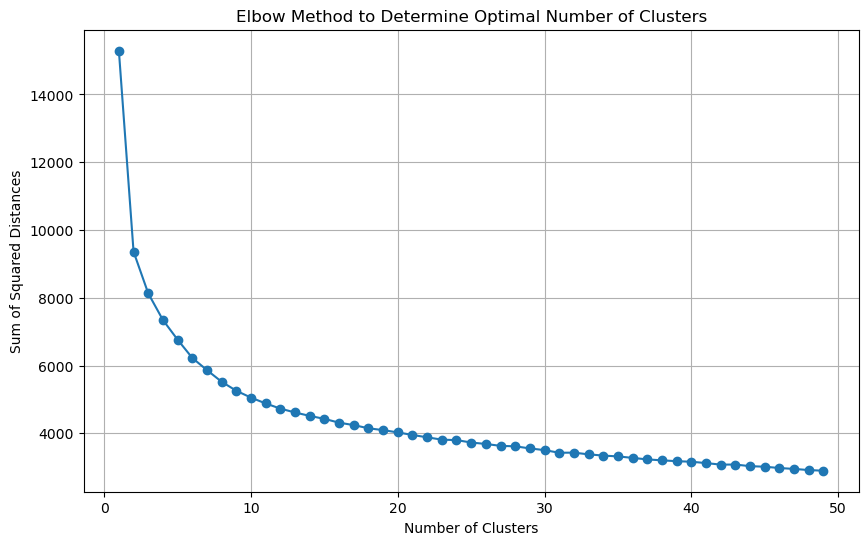

In [39]:
def calculate_sse(embeddings, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
        # Ensure embeddings are 2-dimensional: (n_samples, n_features)
        embeddings_2d = embeddings.reshape(len(embeddings), -1)
        kmeans.fit(embeddings_2d)
        sse.append(kmeans.inertia_)
    return sse

def plot_elbow_curve(k_range, sse):
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.grid(True)
    plt.show()

if isinstance(embeddings, torch.Tensor):
    embeddings_np = embeddings.cpu().detach().numpy()
else:
    embeddings_np = embeddings

k_range = range(1, 50)
sse = calculate_sse(embeddings_np, k_range)
plot_elbow_curve(k_range, sse)

Run K-Means

In [41]:
k = 20  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
embeddings_2d = embeddings_np.reshape(embeddings_np.shape[0], -1)
kmeans.fit(embeddings_2d)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

Embedding 50 belongs to cluster 0
Embedding 350 belongs to cluster 2


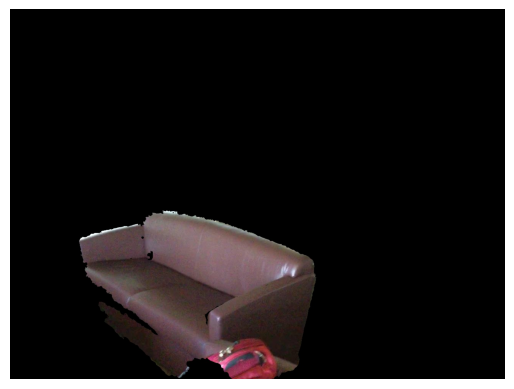

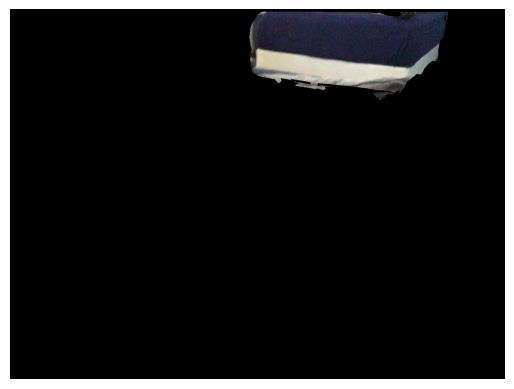

In [45]:
def print_frames_pair(embedding_index_1, embedding_index_2, images_folder_1, images_folder_2):
    for idx, filename in enumerate(sorted(os.listdir(images_folder_1))):
        if idx == embedding_index_1:
            img_path = os.path.join(images_folder_1, filename)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
    for idx, filename in enumerate(sorted(os.listdir(images_folder_2))):
        if idx == embedding_index_2:
            img_path = os.path.join(images_folder_2, filename)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

emb_idx_1 = 50
emb_idx_2 = 350

print(f"Embedding {emb_idx_1} belongs to cluster {kmeans.labels_[emb_idx_1]}")
print(f"Embedding {emb_idx_2} belongs to cluster {kmeans.labels_[emb_idx_2]}")
images_folder_1 = os.path.join(current_directory, f"outputs/masked_images/project_with_occlusion/{scene_1}/{object_id_1}")
images_folder_2 = os.path.join(current_directory, f"outputs/masked_images/project_with_occlusion/{scene_2}/{object_id_2}")
print_frames_pair(emb_idx_1, emb_idx_2 - num_embeddings_1, images_folder_1, images_folder_2)

Show labels of each frame

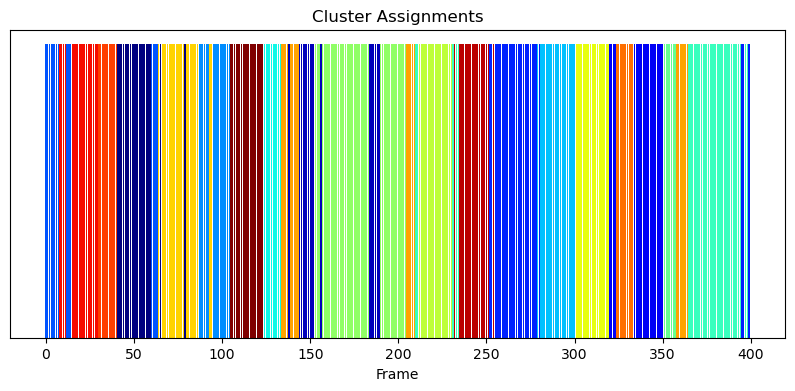

In [42]:
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))
bar_colors = [label_to_color[label] for label in labels]

plt.figure(figsize=(10, 4))
bar_positions = np.arange(len(labels))
plt.bar(bar_positions, np.ones_like(labels), color=bar_colors)

plt.xlabel('Frame')
plt.yticks([])
plt.title('Cluster Assignments')
plt.show()

Show Cosine Similarity Matrix of cluster centers

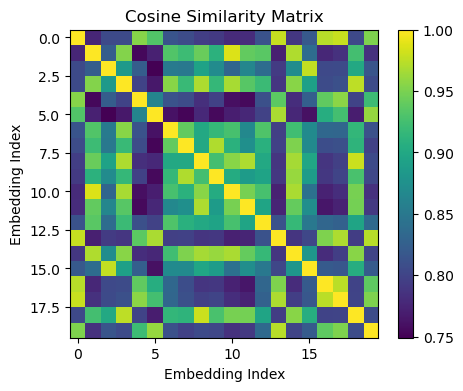

In [46]:
similarity_matrix_center_clusters = cosine_similarity(cluster_centers)
plot_similarity_matrix(similarity_matrix_center_clusters)